# Пример использования библиотеки BigARTM для тематического моделирования
## Для Bigartm v0.8.0
### Редактировал Максим Чурилин

Импортируем BigARTM:

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import artm

In [3]:
artm.version()

'0.10.0'

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [4]:
batch_vectorizer = artm.BatchVectorizer(data_path="school.txt", data_format="vowpal_wabbit", target_folder="school_batches", 
                                       batch_size=100)

В следующий раз данные можно считывать уже из батчей:

In [5]:
batch_vectorizer = artm.BatchVectorizer(data_path="school_batches", data_format='batches')

Создаем объект модели:

In [6]:
T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1}, 
                       num_document_passes=1, reuse_theta=True, cache_theta=True, seed=-1)
# число после названия модальностей - это их веса

Создаем словарь и инициализируем модель с его помощью

In [7]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

In [8]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                           dictionary='dictionary'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

In [9]:
model_artm.initialize('dictionary')

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [10]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

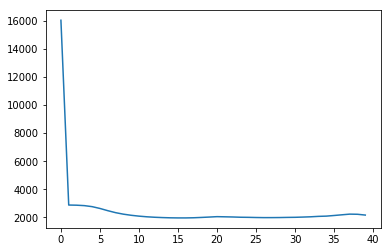

In [11]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

Выведем топы слов:

In [12]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  который быть что это человек этот как свой для они его весь такой время себя
sbj1:  возведение a b множитель раскладывать x выражение умножение скобка разложение сокращенный квадрат ответ переменный целый
sbj2:  обособление куприн слово раскольников мастер роман словосочетание маргарита подчинительный соня оборот вера браслет старик сантьяго
sbj3:  который быть год свой время государство человек мир становиться северный жизнь первый война африка ребенок
sbj4:  x a b уравнение дробь квадратный y степень функция число f решение корень c пример
sbj5:  быть пушкин год функция свой его русский который поэт империя a культура весь f трение
sbj6:  сила быть тело энергия поле при магнитный точка географический наречие если частица например заряд величина
sbj7:  который что это как человек для этот такой быть являться мочь себя она его свой
sbj8:  который быть что это свой как этот человек для x они такой государство a весь
sbj9:  который быть что этот это как человек свой для такой весь

Давайте посмотрим также на разреженность матриц:

In [13]:
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.733374714851
0.165546223521


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [14]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=100, dictionary=dictionary))
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

In [15]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [16]:
for topic_name in model_artm.topic_names:
    if topic_name not in tokens:
        continue
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  который быть что это человек этот как свой для они такой весь его себя время
sbj1:  который быть что это этот человек как свой для такой они весь его год жизнь
sbj2:  который быть что это этот человек как свой для такой они весь его год жизнь
sbj3:  который быть что это как человек этот для свой такой год весь они являться мочь
sbj4:  x a b число уравнение дробь корень степень функция получать квадратный y при пример решение
sbj5:  быть функция пушкин a x точка трение существительное предложение звук падеж слово b язык f
sbj6:  который быть что это этот человек как свой для такой они весь его год жизнь
sbj7:  герой что x a произведение лермонтов его поле поэт магнитный y человек стихотворение это литература
sbj8:  который быть что это свой как этот человек для они такой государство x весь его
sbj9:  который быть что это этот человек как свой весь для его такой они жизнь год


In [17]:
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.0
0.247058823705


Попробуем менять коэффициент регуляризации:

In [18]:
model_artm.regularizers['SparsePhi'].tau = -5*1e4

In [19]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [20]:
model_artm.score_tracker['top_words'].last_tokens

{u'sbj0': [u'\u0441\u043b\u043e\u0432\u043e',
  u'\u043f\u0440\u0435\u0434\u043b\u043e\u0436\u0435\u043d\u0438\u0435',
  u'\u0432\u043e\u0434\u0430',
  u'\u043a\u043e\u0440\u0435\u043d\u044c',
  u'\u0434\u0440\u0435\u0432\u043d\u0438\u0439',
  u'\u043a\u0432\u0430\u0434\u0440\u0430\u0442\u043d\u044b\u0439',
  u'\u0440\u0435\u0447\u044c',
  u'\u0434\u043e\u043c',
  u'n',
  u'\u043e\u043a\u0435\u0430\u043d',
  u'\u0434\u0443\u0448\u0430',
  u'\u0441\u043e\u0431\u0441\u0442\u0432\u0435\u043d\u043d\u044b\u0439',
  u'\u043a\u0440\u0435\u0441\u0442\u044c\u044f\u043d\u0438\u043d',
  u'\u0430\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440',
  u'\u0437\u043e\u043d\u0430'],
 u'sbj3': [u'\u043e\u0442\u043d\u043e\u0448\u0435\u043d\u0438\u0435',
  u'\u0441\u0435\u0432\u0435\u0440\u043d\u044b\u0439',
  u'\u0430\u0444\u0440\u0438\u043a\u0430',
  u'\u043e\u043f\u0440\u0435\u0434\u0435\u043b\u044f\u0442\u044c',
  u'\u0441\u0444\u0435\u0440\u0430',
  u'\u043a\u043e\u043d\u0444\u043b\u0438\u043a\u0442',

In [21]:
for topic_name in model_artm.topic_names:
    if topic_name not in tokens:
        continue
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  слово предложение вода корень древний квадратный речь дом n океан душа собственный крестьянин александр зона
sbj3:  отношение северный африка определять сфера конфликт качество географический площадь ресурс материк ядерный среда гражданин цивилизация
sbj5:  пушкин восстание трение существительное английский павел падеж брат is слабый дорога плазма are частота декабрист
sbj7:  лермонтов поэма толстой y лиза общение детство поведение ничто союзный этикет горе басня напряженность чехов
sbj8:  уравнение сторона движение условие различный чувство выражение армия семья возникать решать дробь житель c звук
sbj9:  который быть что это этот человек как свой для такой они весь его год жизнь


In [22]:
# еще раз посмотрим на разреженность
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.902043581009
0.493907570839


Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [23]:
model_artm.save("my_model")

In [24]:
model_artm.load("my_model")

NameError: global name 'transaction_typenames' is not defined

Можно попросить матрицы в чистом виде:

In [25]:
phi = model_artm.get_phi()

In [26]:
phi

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
"(text, ящерица)",0.000072,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
"(text, щитомордник)",0.000072,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
"(text, пресмыкаться)",0.000072,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
"(text, кречетка)",0.000072,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
"(text, жаворонок)",0.000072,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
"(text, засолить)",0.000072,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
"(text, жаркое)",0.000072,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
"(text, пустыньЗанимают)",0.000072,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
"(text, беляк)",0.000072,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
"(text, рябчик)",0.000072,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


Матрица вероятностей тем в документах.

In [27]:
theta = model_artm.get_theta()
theta

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
sbj0,0.060932,0.020619,0.086420,0.043321,0.082112,0.031674,0.011429,0.030864,0.077739,0.047059,...,0.272131,0.183784,0.340407,0.468641,0.435334,0.548011,0.360604,0.169611,0.227273,0.454971
sbj1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj3,0.032258,0.037801,0.090535,0.050542,0.023460,0.054299,0.011429,0.027778,0.031802,0.017647,...,0.045902,0.040541,0.041379,0.019454,0.049536,0.036145,0.046448,0.081272,0.019481,0.104167
sbj4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj5,0.021505,0.030928,0.004115,0.010830,0.014663,0.009050,0.000000,0.018519,0.003534,0.000000,...,0.016393,0.002703,0.010996,0.035714,0.003096,0.060423,0.005516,0.024735,0.019481,0.062500
sbj6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.005405,0.003769,0.029762,0.000000,0.006024,0.000000,0.000000,0.006494,0.002976
sbj8,0.336917,0.264605,0.230452,0.339350,0.222874,0.321267,0.725714,0.203704,0.204947,0.417647,...,0.059016,0.067568,0.086207,0.041667,0.041446,0.024096,0.081967,0.060071,0.181818,0.030148
sbj9,0.548387,0.646048,0.588478,0.555957,0.656891,0.583711,0.251429,0.719135,0.681979,0.517647,...,0.606557,0.699999,0.517241,0.404762,0.470588,0.325302,0.505464,0.664311,0.545455,0.345238


Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [28]:
theta_test = model_artm.transform(batch_vectorizer)